In [1]:
import numpy as np
import qnm
import bilby
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def shift_model(time, ts, tau, tau_q, fo, f_q, phi, phi_q, A, Aq, t0, **kwargs):
    
    """ 
    
    quantum shift (not fractional)
    
    
    """
    
    plus = np.zeros(len(time))
    cross = np.zeros(len(time))
    
    tidxg = time >= t0
    tidxq = time >= ts
    
    GR_part = A*np.exp(-(time[tidxg]-t0)/tau)*np.exp(1j*((time[tidxg]-t0)*2*np.pi*fo) + phi)
    
    
    plus[tidxg] += GR_part.real 
    
    plus[tidxq] += Q_part.real
    
    return {'plus': plus, 'cross': cross}

In [3]:
def frac_shift_1(time, frac_dw, frac_dtau, dphi, A, w, ts, phi, tau, **kwargs):
    
    """ 
    
    fractional shift: 1 Q mode 
    
    frac_dw, frac_dtau are defined as dw/w (or dtau/tau)
    ts is Q mode start time, phi is phase, w is angular freq., tau is damping time (assumed negative)
        
    outputs plus and cross polarizations as dictionary
    
    get Q values from create_bru_dict function
    
    """
    
    wave = np.zeros(len(time), np.complex128)
    
    tidq = time >= ts
     
    omegar_term = w * (frac_dw) #q_w/w
    time_term_q = (time[tidq] - ts)
    phi_term = phi + dphi
    tau_term = tau * (frac_dtau)
    
    wave[tidq] = A * np.exp(1j*(omegar_term*time_term_q)) * np.exp(1j*(phi_term)) * np.exp(time_term_q/(tau*frac_dtau))
    
    return {'plus': wave.real, 'cross': wave.imag}

In [4]:
def frac_shift_2(time, frac_dw, frac_dtau, frac_amp, dphi, A, t0, w, ts, phi, tau, **kwargs):
    
    """ 
    
    fractional shift: superposition of 1 GR mode and 1 Q mode 
    
    get Q values from create_bru_dict function 
    
    get GR values from qnm package
    
    """
    
    wave = np.zeros(len(time), np.complex128)
    
    tidq = time >= ts
    tidg = time >= t0
    
    amplitude = A
    omegar_term = w * (frac_dw)
    time_term_q = (time[tidq] - ts)
    time_term_g = (time[tidg] - t0)
    phi_term = phi + dphi
    tau_term = tau * (frac_dtau)
    
    wave[tidq] += amplitude * np.exp(1j*(omegar_term*time_term_q)) * np.exp(1j*(phi_term)) * np.exp(time_term_q/(tau*frac_dtau))
    wave[tidg] += amplitude * np.exp(1j*(w*time_term_g)) * np.exp(1j*(phi)) * np.exp(time_term_g/(tau))
    
    return {'plus': wave.real, 'cross': wave.imag}

In [5]:
def create_bru_values(m_odd, em, M, a, n_ref, A):
    
    """ 
    m_odd is odd integer, g_s is string coupling (GR == 1), em is 2,
    M is total mass, a is dimensionless spin, and amplitude_qnm is 
    the amplitude of the mode of interest 
    
    returns dictionary: amplitude (quantum, g_s version), omega_real, tau, ts, freq
    outputs tau as a negative number
    
    a refractive index of 1 implies no leakage, AND does not work in this limit (n ~ 1/g_s)
    only the subrelativistic (slow) modes can escape (n>>1) based on boundary conditions 
    (the boundary conditions being the fact that this is a BH copycat)
        
    something to consider is that g_s cannot 0 (which it is in GR) in this model, otherwise there will be 
    no leakage or coupling to outside the "event horizon," which allows stuff to escape
        
    From previous work we can constrain g_s^2 to, at max, be 0.6, which is corresponds to n=1.2
    (this n won't work for this approximation anyway, because the modes close to n = 1 will not 
    escape)
        
    So: pick a g_s that is small but not too small! Strings gotta couple at least for stringy deviations, 
    so n can't be very big 
    
    Also, larger n will result in lower frequency: we can't go too low! LIGO gets real noisy
    if f is too low
        higher mass systems will also be low in frequency, so it's a balancing act
    
        
         
    """
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    g_s = 1/n_ref
    
    conversion_w = (c**3)/(G * M * Msun)
    R_con = (2 * G * M * Msun) / (c**2)
    
    r_s = (R_con + np.sqrt((R_con**2) - 4*(a**2)))/2 #units m, kerr+ radius 
    omega_real = (m_odd * np.pi /(2 * r_s * n_ref)) * c   #units 1/m --> 1/s
    omega_im = - (1/r_s) * (1/(n_ref**2)) * c
    
    tau = 1/omega_im
    ts = 1/omega_real 
    
    
    print("Q freq is {}".format(omega_real/(2*np.pi)))
    #print("Q tau is {}".format(tau))
    
    return {'omega_real_Q': omega_real,
            'tau_Q': tau, 'ts_Q': ts}

In [6]:
def create_GR_values(s, l, m, n, a, M):

    """
    grabs GR values to compare to quantum values
    assumes M in units Msun
    converts from 1/m --> 1/s for angular frequency using GR conversion
    
    returns dictionary of GR tau and GR real omega
    outputs tau as a negative number
    
    """
    
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    conversion_w = (c**3)/(G * M * Msun)
    
    grav = qnm.modes_cache(s=s,l=l,m=m,n=n)
    omega_GR, _, _ = grav(a=a)
    
    omega_real_GR = omega_GR.real * conversion_w
    omega_im_GR = omega_GR.imag * conversion_w
    tau_GR = 1/omega_im_GR
    
    print("GR freq is {}".format(omega_real_GR/(2*np.pi)))
    #print("GR tau is {}".format(tau_GR))
    
    return {'tau_GR': tau_GR, 'omega_real_GR': omega_real_GR}

In [7]:
def calc_fracs(tau_GR, tau_Q, omega_real_GR, omega_real_Q, **kwargs):
    
    w = omega_real_GR
    w_q = omega_real_Q
    #dw = w - w_q
    frac_dw = w_q/w
    
    print('frac_dw is {}'.format(frac_dw))
    tau = tau_GR
    tau_q = tau_Q
    #dtau = np.abs(tau-tau_q)
    frac_dtau = tau_q/tau
    
    return {'frac_dtau': frac_dtau, 'frac_dw': frac_dw}

In [12]:
def main(s, l, m, n, a, t0, n_ref, A, Mass_list, outdir):
    
    
    df = pd.DataFrame(columns={'frac_dw','w','H1_SNR','frac_dtau','tau','L1_SNR', 'log_bayes_factor'}, 
                      index=Mass_list)
    
    for value in Mass_list:
        
        #create GR/bru values
        GR_values = create_GR_values(s, l , m, n, a, value) #(s, l, m, n, a, M)
        Q_values = create_bru_values(1, 2, value, a, n_ref, A) #(m_odd, em, M, a, n_ref, A)
        
    
        #create fractional shifts
        fracs = calc_fracs(tau_GR=GR_values['tau_GR'], tau_Q=Q_values['tau_Q'], 
                           omega_real_GR=GR_values['omega_real_GR'], 
                           omega_real_Q=Q_values['omega_real_Q'])
        
        injection_parameters = dict(frac_dw=fracs['frac_dw'], frac_dtau=fracs['frac_dtau'], 
                            dphi=0, A=A, w=GR_values['omega_real_GR'], t0=0, phi=0, 
                            tau=GR_values['tau_GR'], geocent_time=0, ra=0, dec=0, psi=0, 
                            ts=0)
        
        print(injection_parameters)
        waveform = bilby.gw.waveform_generator.WaveformGenerator(
                    duration=1, sampling_frequency=4096,
                    time_domain_source_model=frac_shift_1,
                    start_time=injection_parameters['geocent_time'])
        
        #plot waveform for sanity check
        times = waveform.time_array
        wave = frac_shift_1(times, **injection_parameters)['plus']
        plt.plot(times, wave, label=value)
        plt.xlim(0,1)
        plt.xlabel('time (s)')
        plt.ylabel('amp')
        plt.legend()
        plt.show()
        
        ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
        ifos.set_strain_data_from_power_spectral_densities(
            sampling_frequency=4096, duration=1,
            start_time=injection_parameters['geocent_time'])
        
        ifos.inject_signal(waveform_generator=waveform, parameters=injection_parameters)
        
        #create priors
        prior = injection_parameters.copy()
        prior['frac_dtau'] = bilby.core.prior.Uniform(0, 20, r'$d\tau/\tau}$')
        prior['frac_dw'] = bilby.core.prior.Uniform(0, 1, r'$d\omega/\omega$')
        
        #create likelihood
        likelihood = bilby.gw.GravitationalWaveTransient(
                    interferometers=ifos, waveform_generator=waveform)
        
        result = bilby.run_sampler(
            likelihood=likelihood, priors=prior, sampler='dynesty', npoints=500, walks=10, 
            nact=5, injection_parameters=injection_parameters, outdir=outdir, 
            label='mass{}_220_{}_{}'.format(value, n_ref, A), resume=False)
        
        df.loc[value] = {'frac_dw': injection_parameters['frac_dw'],
                         'w':injection_parameters['w'],
                         'H1_SNR': ifos.meta_data['H1']['optimal_SNR'],
                         'L1_SNR': ifos.meta_data['L1']['optimal_SNR'],
                         'frac_dtau': injection_parameters['frac_dtau'],
                         'tau': injection_parameters['tau'],
                         'log_bayes_factor': result.log_bayes_factor}
        
        result.plot_corner(save=True)
    
    return df

GR freq is 862.5705847051892
Q freq is 254.39768806966646
frac_dw is 0.2949297049778424
{'frac_dw': 0.2949297049778424, 'frac_dtau': 4.039643657181079, 'dphi': 0, 'A': 9e-22, 'w': 5419.690824224949, 't0': 0, 'phi': 0, 'tau': -0.0012163366581207057, 'geocent_time': 0, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0}


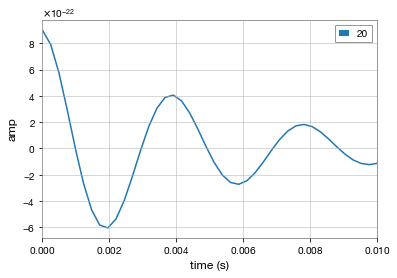

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
17:59 bilby INFO    : Injected signal in H1:
17:59 bilby INFO    :   optimal SNR = 7.89
17:59 bilby INFO    :   matched filter SNR = 8.28+0.98j
17:59 bilby INFO    :   frac_dw = 0.2949297049778424
17:59 bilby INFO    :   frac_dtau = 4.039643657181079
17:59 bilby INFO    :   dphi = 0
17:59 bilby INFO    :   A = 9e-22
17:59 bilby INFO    :   w = 5419.690824224949
17:59 bilby INFO    :   t0 = 0
17:59 bilby INFO    :   phi = 0
17:59 bilby INFO    :   tau = -0.0012163366581207057
17:59 bilby INFO    :   geocent_time = 0
17:59 bilby INFO    :   ra = 0
17:59 bilby INFO    :   dec = 0
17:59 bilby INFO    :   psi = 0
17:59 bilby INFO    :   ts = 0
17:59 bilby INFO    : Injected signal in L1:
17:59 bilby INFO    :   optimal SNR = 9.43
17:59 

0it [00:00, ?it/s]

17:59 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1333c4690>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
17:59 bilby INFO    : Checkpoint every n_check_point = 400000
17:59 bilby INFO    : Using dynesty version 1.0.1
17:59 bilby INFO    : Using the bilby-implemented rwalk sample me

4945it [03:17, 17.82it/s, bound:484 nc:53 ncall:172938 eff:2.9% logz-ratio=75.84+/-0.16 dlogz:0.100>0.10]

18:02 bilby INFO    : Writing checkpoint file outdir_07224020_n5_tschange//mass20_220_5_9e-22_resume.pickle



4946it [03:18, 24.95it/s, bound:484 nc:1 ncall:172987 eff:3.1% logz-ratio=75.94+/-0.16 dlogz:0.000>0.10] 



18:02 bilby INFO    : Sampling time: 0:03:16.762395
18:02 bilby INFO    : Summary of results:
nsamples: 5446
log_noise_evidence: -4070.192
log_evidence: -3994.253 +/-  0.161
log_bayes_factor: 75.939 +/-  0.161



GR freq is 431.2852923525946
Q freq is 127.19884402138752
frac_dw is 0.2949297049466665
{'frac_dw': 0.2949297049466665, 'frac_dtau': 4.039643657608094, 'dphi': 0, 'A': 9e-22, 'w': 2709.8454121124746, 't0': 0, 'phi': 0, 'tau': -0.0024326733162414113, 'geocent_time': 0, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0}


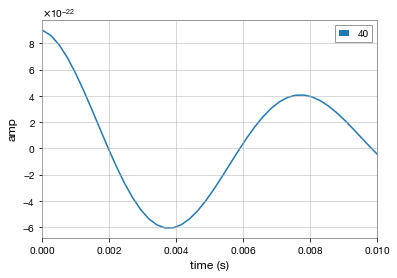

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
18:02 bilby INFO    : Injected signal in H1:
18:02 bilby INFO    :   optimal SNR = 10.63
18:02 bilby INFO    :   matched filter SNR = 10.24+0.22j
18:02 bilby INFO    :   frac_dw = 0.2949297049466665
18:02 bilby INFO    :   frac_dtau = 4.039643657608094
18:02 bilby INFO    :   dphi = 0
18:02 bilby INFO    :   A = 9e-22
18:02 bilby INFO    :   w = 2709.8454121124746
18:02 bilby INFO    :   t0 = 0
18:02 bilby INFO    :   phi = 0
18:02 bilby INFO    :   tau = -0.0024326733162414113
18:02 bilby INFO    :   geocent_time = 0
18:02 bilby INFO    :   ra = 0
18:02 bilby INFO    :   dec = 0
18:02 bilby INFO    :   psi = 0
18:02 bilby INFO    :   ts = 0
18:02 bilby INFO    : Injected signal in L1:
18:02 bilby INFO    :   optimal SNR = 12.75
18

0it [00:00, ?it/s]

18:02 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x135470210>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
18:02 bilby INFO    : Checkpoint every n_check_point = 500000
18:02 bilby INFO    : Using dynesty version 1.0.1
18:02 bilby INFO    : Using the bilby-implemented rwalk sample me

5152it [03:32, 17.40it/s, bound:532 nc:49 ncall:186454 eff:2.8% logz-ratio=118.38+/-0.17 dlogz:0.100>0.10]

18:06 bilby INFO    : Writing checkpoint file outdir_07224020_n5_tschange//mass40_220_5_9e-22_resume.pickle



5152it [03:32, 24.21it/s, bound:532 nc:1 ncall:186454 eff:3.0% logz-ratio=118.47+/-0.17 dlogz:0.000>0.10] 



18:06 bilby INFO    : Sampling time: 0:03:31.360911
18:06 bilby INFO    : Summary of results:
nsamples: 5652
log_noise_evidence: -4150.076
log_evidence: -4031.601 +/-  0.166
log_bayes_factor: 118.475 +/-  0.166



GR freq is 287.523528235063
Q freq is 84.79922934593168
frac_dw is 0.2949297049408931
{'frac_dw': 0.2949297049408931, 'frac_dtau': 4.039643657687172, 'dphi': 0, 'A': 9e-22, 'w': 1806.5636080749828, 't0': 0, 'phi': 0, 'tau': -0.0036490099743621174, 'geocent_time': 0, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0}


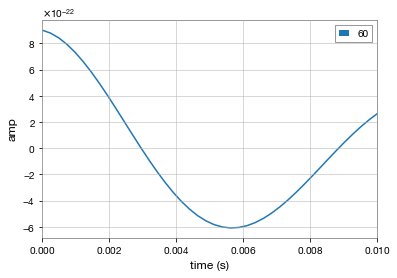

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
18:06 bilby INFO    : Injected signal in H1:
18:06 bilby INFO    :   optimal SNR = 12.14
18:06 bilby INFO    :   matched filter SNR = 12.08+0.97j
18:06 bilby INFO    :   frac_dw = 0.2949297049408931
18:06 bilby INFO    :   frac_dtau = 4.039643657687172
18:06 bilby INFO    :   dphi = 0
18:06 bilby INFO    :   A = 9e-22
18:06 bilby INFO    :   w = 1806.5636080749828
18:06 bilby INFO    :   t0 = 0
18:06 bilby INFO    :   phi = 0
18:06 bilby INFO    :   tau = -0.0036490099743621174
18:06 bilby INFO    :   geocent_time = 0
18:06 bilby INFO    :   ra = 0
18:06 bilby INFO    :   dec = 0
18:06 bilby INFO    :   psi = 0
18:06 bilby INFO    :   ts = 0
18:06 bilby INFO    : Injected signal in L1:
18:06 bilby INFO    :   optimal SNR = 14.64
18

0it [00:00, ?it/s]

18:06 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1331ab5d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
18:06 bilby INFO    : Checkpoint every n_check_point = 500000
18:06 bilby INFO    : Using dynesty version 1.0.1
18:06 bilby INFO    : Using the bilby-implemented rwalk sample me

5379it [03:40, 18.20it/s, bound:548 nc:49 ncall:193916 eff:2.8% logz-ratio=141.76+/-0.17 dlogz:0.100>0.10]

18:10 bilby INFO    : Writing checkpoint file outdir_07224020_n5_tschange//mass60_220_5_9e-22_resume.pickle



5380it [03:40, 24.36it/s, bound:549 nc:1 ncall:193968 eff:3.0% logz-ratio=141.86+/-0.17 dlogz:0.000>0.10] 



18:10 bilby INFO    : Sampling time: 0:03:39.408649
18:10 bilby INFO    : Summary of results:
nsamples: 5880
log_noise_evidence: -4225.581
log_evidence: -4083.724 +/-  0.172
log_bayes_factor: 141.857 +/-  0.172



GR freq is 215.6426461762973
Q freq is 63.599422009013026
frac_dw is 0.29492970493887244
{'frac_dw': 0.29492970493887244, 'frac_dtau': 4.039643657714849, 'dphi': 0, 'A': 9e-22, 'w': 1354.9227060562373, 't0': 0, 'phi': 0, 'tau': -0.004865346632482823, 'geocent_time': 0, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0}


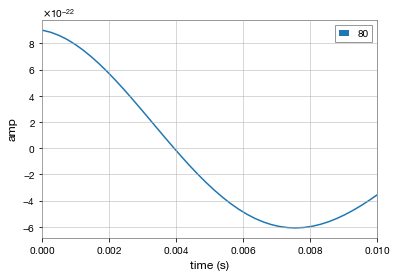

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
18:10 bilby INFO    : Injected signal in H1:
18:10 bilby INFO    :   optimal SNR = 12.87
18:10 bilby INFO    :   matched filter SNR = 14.08+0.24j
18:10 bilby INFO    :   frac_dw = 0.29492970493887244
18:10 bilby INFO    :   frac_dtau = 4.039643657714849
18:10 bilby INFO    :   dphi = 0
18:10 bilby INFO    :   A = 9e-22
18:10 bilby INFO    :   w = 1354.9227060562373
18:10 bilby INFO    :   t0 = 0
18:10 bilby INFO    :   phi = 0
18:10 bilby INFO    :   tau = -0.004865346632482823
18:10 bilby INFO    :   geocent_time = 0
18:10 bilby INFO    :   ra = 0
18:10 bilby INFO    :   dec = 0
18:10 bilby INFO    :   psi = 0
18:10 bilby INFO    :   ts = 0
18:10 bilby INFO    : Injected signal in L1:
18:10 bilby INFO    :   optimal SNR = 15.62
18

0it [00:00, ?it/s]

18:10 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x133cdb490>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
18:10 bilby INFO    : Checkpoint every n_check_point = 500000
18:10 bilby INFO    : Using dynesty version 1.0.1
18:10 bilby INFO    : Using the bilby-implemented rwalk sample me

5456it [11:09, 15.82it/s, bound:572 nc:49 ncall:199799 eff:2.7% logz-ratio=220.44+/-0.17 dlogz:0.100>0.10]

18:21 bilby INFO    : Writing checkpoint file outdir_07224020_n5_tschange//mass80_220_5_9e-22_resume.pickle



5456it [11:09,  8.14it/s, bound:572 nc:1 ncall:199799 eff:3.0% logz-ratio=220.54+/-0.17 dlogz:0.000>0.10] 



18:21 bilby INFO    : Sampling time: 0:11:08.421107
18:21 bilby INFO    : Summary of results:
nsamples: 5956
log_noise_evidence: -4328.117
log_evidence: -4107.579 +/-  0.174
log_bayes_factor: 220.537 +/-  0.174



GR freq is 172.51411694103783
Q freq is 50.879537607049066
frac_dw is 0.29492970493793713
{'frac_dw': 0.29492970493793713, 'frac_dtau': 4.039643657727659, 'dphi': 0, 'A': 9e-22, 'w': 1083.9381648449898, 't0': 0, 'phi': 0, 'tau': -0.006081683290603529, 'geocent_time': 0, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0}


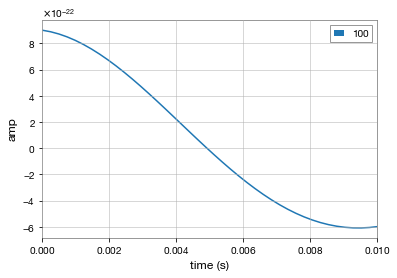

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
18:21 bilby INFO    : Injected signal in H1:
18:21 bilby INFO    :   optimal SNR = 12.92
18:21 bilby INFO    :   matched filter SNR = 12.30-0.26j
18:21 bilby INFO    :   frac_dw = 0.29492970493793713
18:21 bilby INFO    :   frac_dtau = 4.039643657727659
18:21 bilby INFO    :   dphi = 0
18:21 bilby INFO    :   A = 9e-22
18:21 bilby INFO    :   w = 1083.9381648449898
18:21 bilby INFO    :   t0 = 0
18:21 bilby INFO    :   phi = 0
18:21 bilby INFO    :   tau = -0.006081683290603529
18:21 bilby INFO    :   geocent_time = 0
18:21 bilby INFO    :   ra = 0
18:21 bilby INFO    :   dec = 0
18:21 bilby INFO    :   psi = 0
18:21 bilby INFO    :   ts = 0
18:21 bilby INFO    : Injected signal in L1:
18:21 bilby INFO    :   optimal SNR = 15.81
18

0it [00:00, ?it/s]

18:21 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x133da5890>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
18:21 bilby INFO    : Checkpoint every n_check_point = 300000
18:21 bilby INFO    : Using dynesty version 1.0.1
18:21 bilby INFO    : Using the bilby-implemented rwalk sample me

5466it [04:01, 17.11it/s, bound:568 nc:50 ncall:199367 eff:2.7% logz-ratio=190.62+/-0.17 dlogz:0.100>0.10]

18:25 bilby INFO    : Writing checkpoint file outdir_07224020_n5_tschange//mass100_220_5_9e-22_resume.pickle



5466it [04:02, 22.57it/s, bound:568 nc:1 ncall:199367 eff:3.0% logz-ratio=190.71+/-0.17 dlogz:0.000>0.10] 



18:25 bilby INFO    : Sampling time: 0:04:00.601165
18:25 bilby INFO    : Summary of results:
nsamples: 5966
log_noise_evidence: -4246.517
log_evidence: -4055.805 +/-  0.174
log_bayes_factor: 190.712 +/-  0.174



GR freq is 143.7617641175315
Q freq is 42.399614672467855
frac_dw is 0.29492970493742915
{'frac_dw': 0.29492970493742915, 'frac_dtau': 4.039643657734619, 'dphi': 0, 'A': 9e-22, 'w': 903.2818040374914, 't0': 0, 'phi': 0, 'tau': -0.007298019948724235, 'geocent_time': 0, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0}


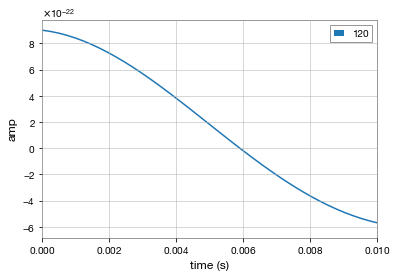

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
18:25 bilby INFO    : Injected signal in H1:
18:25 bilby INFO    :   optimal SNR = 12.47
18:25 bilby INFO    :   matched filter SNR = 11.33-0.16j
18:25 bilby INFO    :   frac_dw = 0.29492970493742915
18:25 bilby INFO    :   frac_dtau = 4.039643657734619
18:25 bilby INFO    :   dphi = 0
18:25 bilby INFO    :   A = 9e-22
18:25 bilby INFO    :   w = 903.2818040374914
18:25 bilby INFO    :   t0 = 0
18:25 bilby INFO    :   phi = 0
18:25 bilby INFO    :   tau = -0.007298019948724235
18:25 bilby INFO    :   geocent_time = 0
18:25 bilby INFO    :   ra = 0
18:25 bilby INFO    :   dec = 0
18:25 bilby INFO    :   psi = 0
18:25 bilby INFO    :   ts = 0
18:25 bilby INFO    : Injected signal in L1:
18:25 bilby INFO    :   optimal SNR = 15.40
18:

0it [00:00, ?it/s]

18:25 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1356233d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
18:25 bilby INFO    : Checkpoint every n_check_point = 400000
18:25 bilby INFO    : Using dynesty version 1.0.1
18:25 bilby INFO    : Using the bilby-implemented rwalk sample me

5352it [03:46, 17.22it/s, bound:547 nc:49 ncall:193545 eff:2.8% logz-ratio=176.01+/-0.17 dlogz:0.100>0.10]

18:29 bilby INFO    : Writing checkpoint file outdir_07224020_n5_tschange//mass120_220_5_9e-22_resume.pickle



5353it [03:46, 23.61it/s, bound:548 nc:1 ncall:193599 eff:3.0% logz-ratio=176.11+/-0.17 dlogz:0.000>0.10] 



18:29 bilby INFO    : Sampling time: 0:03:45.271963
18:29 bilby INFO    : Summary of results:
nsamples: 5853
log_noise_evidence: -4242.092
log_evidence: -4065.983 +/-  0.171
log_bayes_factor: 176.109 +/-  0.171



GR freq is 123.22436924359845
Q freq is 36.34252686207756
frac_dw is 0.29492970493712284
{'frac_dw': 0.29492970493712284, 'frac_dtau': 4.039643657738814, 'dphi': 0, 'A': 9e-22, 'w': 774.2415463178498, 't0': 0, 'phi': 0, 'tau': -0.00851435660684494, 'geocent_time': 0, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0}


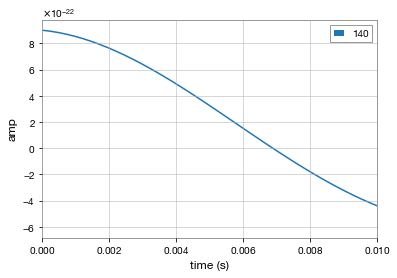

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
18:29 bilby INFO    : Injected signal in H1:
18:29 bilby INFO    :   optimal SNR = 11.71
18:29 bilby INFO    :   matched filter SNR = 12.65-0.32j
18:29 bilby INFO    :   frac_dw = 0.29492970493712284
18:29 bilby INFO    :   frac_dtau = 4.039643657738814
18:29 bilby INFO    :   dphi = 0
18:29 bilby INFO    :   A = 9e-22
18:29 bilby INFO    :   w = 774.2415463178498
18:29 bilby INFO    :   t0 = 0
18:29 bilby INFO    :   phi = 0
18:29 bilby INFO    :   tau = -0.00851435660684494
18:29 bilby INFO    :   geocent_time = 0
18:29 bilby INFO    :   ra = 0
18:29 bilby INFO    :   dec = 0
18:29 bilby INFO    :   psi = 0
18:29 bilby INFO    :   ts = 0
18:29 bilby INFO    : Injected signal in L1:
18:29 bilby INFO    :   optimal SNR = 14.63
18:2

0it [00:00, ?it/s]

18:29 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x134860350>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
18:29 bilby INFO    : Checkpoint every n_check_point = 400000
18:29 bilby INFO    : Using dynesty version 1.0.1
18:29 bilby INFO    : Using the bilby-implemented rwalk sample me

5305it [28:16, 16.54it/s, bound:537 nc:53 ncall:190161 eff:2.8% logz-ratio=176.08+/-0.17 dlogz:0.100>0.10] 

18:57 bilby INFO    : Writing checkpoint file outdir_07224020_n5_tschange//mass140_220_5_9e-22_resume.pickle



5306it [28:17,  3.13it/s, bound:537 nc:1 ncall:190212 eff:3.1% logz-ratio=176.18+/-0.17 dlogz:0.000>0.10] 



18:57 bilby INFO    : Sampling time: 0:28:15.802956
18:57 bilby INFO    : Summary of results:
nsamples: 5806
log_noise_evidence: -4189.318
log_evidence: -4013.140 +/-  0.171
log_bayes_factor: 176.178 +/-  0.171



GR freq is 107.82132308814865
Q freq is 31.799711004296423
frac_dw is 0.29492970493692394
{'frac_dw': 0.29492970493692394, 'frac_dtau': 4.0396436577415376, 'dphi': 0, 'A': 9e-22, 'w': 677.4613530281187, 't0': 0, 'phi': 0, 'tau': -0.009730693264965645, 'geocent_time': 0, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0}


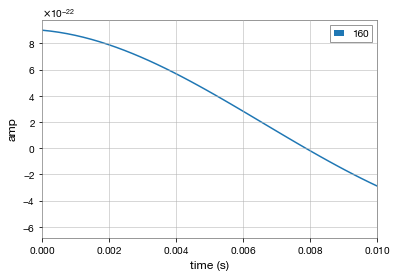

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
18:57 bilby INFO    : Injected signal in H1:
18:57 bilby INFO    :   optimal SNR = 10.84
18:57 bilby INFO    :   matched filter SNR = 10.20-0.03j
18:57 bilby INFO    :   frac_dw = 0.29492970493692394
18:57 bilby INFO    :   frac_dtau = 4.0396436577415376
18:57 bilby INFO    :   dphi = 0
18:57 bilby INFO    :   A = 9e-22
18:57 bilby INFO    :   w = 677.4613530281187
18:57 bilby INFO    :   t0 = 0
18:57 bilby INFO    :   phi = 0
18:57 bilby INFO    :   tau = -0.009730693264965645
18:57 bilby INFO    :   geocent_time = 0
18:57 bilby INFO    :   ra = 0
18:57 bilby INFO    :   dec = 0
18:57 bilby INFO    :   psi = 0
18:57 bilby INFO    :   ts = 0
18:57 bilby INFO    : Injected signal in L1:
18:57 bilby INFO    :   optimal SNR = 13.72
18

0it [00:00, ?it/s]

18:57 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x124ecd5d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
18:57 bilby INFO    : Checkpoint every n_check_point = 400000
18:57 bilby INFO    : Using dynesty version 1.0.1
18:57 bilby INFO    : Using the bilby-implemented rwalk sample me

5154it [03:41, 16.62it/s, bound:524 nc:49 ncall:185219 eff:2.8% logz-ratio=133.56+/-0.17 dlogz:0.100>0.10]

19:01 bilby INFO    : Writing checkpoint file outdir_07224020_n5_tschange//mass160_220_5_9e-22_resume.pickle



5155it [03:41, 23.23it/s, bound:524 nc:1 ncall:185268 eff:3.1% logz-ratio=133.66+/-0.17 dlogz:0.000>0.10] 



19:01 bilby INFO    : Sampling time: 0:03:40.393577
19:01 bilby INFO    : Summary of results:
nsamples: 5655
log_noise_evidence: -4062.582
log_evidence: -3928.924 +/-  0.167
log_bayes_factor: 133.658 +/-  0.167



GR freq is 95.84117607835434
Q freq is 28.26640978158375
frac_dw is 0.2949297049367876
{'frac_dw': 0.2949297049367876, 'frac_dtau': 4.039643657743405, 'dphi': 0, 'A': 9e-22, 'w': 602.1878693583276, 't0': 0, 'phi': 0, 'tau': -0.010947029923086353, 'geocent_time': 0, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0}


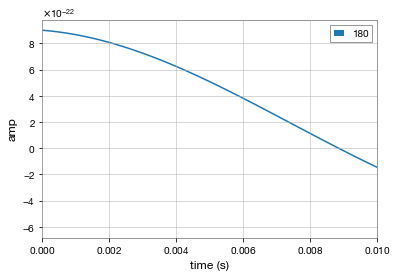

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
19:01 bilby INFO    : Injected signal in H1:
19:01 bilby INFO    :   optimal SNR = 9.99
19:01 bilby INFO    :   matched filter SNR = 11.27-0.51j
19:01 bilby INFO    :   frac_dw = 0.2949297049367876
19:01 bilby INFO    :   frac_dtau = 4.039643657743405
19:01 bilby INFO    :   dphi = 0
19:01 bilby INFO    :   A = 9e-22
19:01 bilby INFO    :   w = 602.1878693583276
19:01 bilby INFO    :   t0 = 0
19:01 bilby INFO    :   phi = 0
19:01 bilby INFO    :   tau = -0.010947029923086353
19:01 bilby INFO    :   geocent_time = 0
19:01 bilby INFO    :   ra = 0
19:01 bilby INFO    :   dec = 0
19:01 bilby INFO    :   psi = 0
19:01 bilby INFO    :   ts = 0
19:01 bilby INFO    : Injected signal in L1:
19:01 bilby INFO    :   optimal SNR = 12.81
19:01

0it [00:00, ?it/s]

19:01 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x124e2cb50>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
19:01 bilby INFO    : Checkpoint every n_check_point = 400000
19:01 bilby INFO    : Using dynesty version 1.0.1
19:01 bilby INFO    : Using the bilby-implemented rwalk sample me

5038it [03:40, 16.57it/s, bound:506 nc:52 ncall:178608 eff:2.8% logz-ratio=145.54+/-0.16 dlogz:0.100>0.10]

19:04 bilby INFO    : Writing checkpoint file outdir_07224020_n5_tschange//mass180_220_5_9e-22_resume.pickle



5039it [03:41, 22.77it/s, bound:506 nc:1 ncall:178657 eff:3.1% logz-ratio=145.64+/-0.16 dlogz:0.000>0.10] 



19:05 bilby INFO    : Sampling time: 0:03:39.802317
19:05 bilby INFO    : Summary of results:
nsamples: 5539
log_noise_evidence: -4260.345
log_evidence: -4114.709 +/-  0.164
log_bayes_factor: 145.635 +/-  0.164



GR freq is 86.25705847051891
Q freq is 25.439768803416968
frac_dw is 0.2949297049366901
{'frac_dw': 0.2949297049366901, 'frac_dtau': 4.03964365774474, 'dphi': 0, 'A': 9e-22, 'w': 541.9690824224949, 't0': 0, 'phi': 0, 'tau': -0.012163366581207058, 'geocent_time': 0, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0}


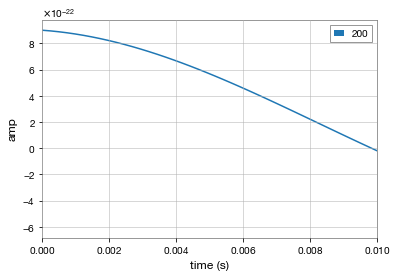

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
19:05 bilby INFO    : Injected signal in H1:
19:05 bilby INFO    :   optimal SNR = 9.19
19:05 bilby INFO    :   matched filter SNR = 9.75+1.44j
19:05 bilby INFO    :   frac_dw = 0.2949297049366901
19:05 bilby INFO    :   frac_dtau = 4.03964365774474
19:05 bilby INFO    :   dphi = 0
19:05 bilby INFO    :   A = 9e-22
19:05 bilby INFO    :   w = 541.9690824224949
19:05 bilby INFO    :   t0 = 0
19:05 bilby INFO    :   phi = 0
19:05 bilby INFO    :   tau = -0.012163366581207058
19:05 bilby INFO    :   geocent_time = 0
19:05 bilby INFO    :   ra = 0
19:05 bilby INFO    :   dec = 0
19:05 bilby INFO    :   psi = 0
19:05 bilby INFO    :   ts = 0
19:05 bilby INFO    : Injected signal in L1:
19:05 bilby INFO    :   optimal SNR = 11.97
19:05 b

0it [00:00, ?it/s]

19:05 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x136bac550>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
19:05 bilby INFO    : Checkpoint every n_check_point = 400000
19:05 bilby INFO    : Using dynesty version 1.0.1
19:05 bilby INFO    : Using the bilby-implemented rwalk sample me

4923it [03:17, 17.28it/s, bound:481 nc:49 ncall:171803 eff:2.9% logz-ratio=105.14+/-0.16 dlogz:0.100>0.10]

19:08 bilby INFO    : Writing checkpoint file outdir_07224020_n5_tschange//mass200_220_5_9e-22_resume.pickle



4924it [03:18, 24.81it/s, bound:481 nc:1 ncall:171852 eff:3.2% logz-ratio=105.24+/-0.16 dlogz:0.000>0.10] 



19:08 bilby INFO    : Sampling time: 0:03:17.084436
19:08 bilby INFO    : Summary of results:
nsamples: 5424
log_noise_evidence: -4154.453
log_evidence: -4049.213 +/-  0.161
log_bayes_factor: 105.240 +/-  0.161



In [25]:
s=-2
l=2
m=2
n=0
a=0.7
Mass_list=[20,40,60,80,100,120,140,160,180,200]
t0=0
n_ref=5
A = 9e-22
outdir = 'outdir_07224020_n5_tschange/'

check = main(s=s, l=l, m=m, n=n, a=a, t0=t0, n_ref=n_ref, A=A,
             Mass_list=Mass_list, outdir=outdir)

In [26]:
check

,H1_SNR,log_bayes_factor,w,L1_SNR,tau,frac_dw,frac_dtau
20,7.88565,75.9393,5419.69,9.431,-0.00121634,0.29493,4.03964
40,10.6301,118.475,2709.85,12.753,-0.00243267,0.29493,4.03964
60,12.1423,141.857,1806.56,14.6409,-0.00364901,0.29493,4.03964
80,12.8693,220.537,1354.92,15.6183,-0.00486535,0.29493,4.03964
100,12.9244,190.712,1083.94,15.8119,-0.00608168,0.29493,4.03964
120,12.4666,176.109,903.282,15.4004,-0.00729802,0.29493,4.03964
140,11.7099,176.178,774.242,14.6296,-0.00851436,0.29493,4.03964
160,10.8432,133.658,677.461,13.7197,-0.00973069,0.29493,4.03964
180,9.98587,145.635,602.188,12.8118,-0.010947,0.29493,4.03964
200,9.19069,105.24,541.969,11.9704,-0.0121634,0.29493,4.03964


In [27]:
check.to_csv(path_or_buf='outdir_07224020_n5_tschange/9e-22_n5_20-200_ts')